# Project Topic

This is a notebook for [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview). The task of this project is to detect cancer in photos taken by microscope. The size of image is 96x96, and when at least one of cancer cell is included in the center 32x32, it is positive. Cancer cells out of this zone is not counted, but accuracy gets much better when whole 96x96 is used. 


**target**

Target of this project is to achieve **auc > 0.9** in kaggle private score by CNN. Because of bias in data, it is even possible to achieve auc 0.8 only according to color in photo (refer to **chapter 2.5 prediction by mean RGB value**). Therefore, CNN must achieve more than auc 0.9. 



In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import cv2
from sklearn import metrics
import gc


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

# 1. Data

There are 220,0025 train data, and it takes about 30min to read all of them. To reduce data preprocessing time, image file (.npy) is created by [another notebook](https://www.kaggle.com/hidetaketakahashi/read-file-for-cancer-detection). Those files can be loaded as numpy array. This file is re-sampled data to balance positive  and negative. 


**data source**

The original data is available in kaggle competition website. 

https://www.kaggle.com/competitions/histopathologic-cancer-detection/data


numpy file is available here:

https://www.kaggle.com/datasets/hidetaketakahashi/cancerdetection-npy

In [4]:
sample_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
label_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

In [5]:
print("n of train data = ", label_df.shape[0])
print("n of test data  = ", sample_df.shape[0])

n of train data =  220025
n of test data  =  57458


In [6]:
fpath = "/kaggle/input/cancerdetection-npy/X_test.npy"
X_test = np.load(fpath)

In [7]:
fpath = "/kaggle/input/cancerdetection-npy/X_val.npy"
X_val = np.load(fpath)

fpath = "/kaggle/input/cancerdetection-npy/y_val.npy"
y_val = np.load(fpath)

Due to memory size restriction, train data size is limited to 50000 for this report.

In [8]:
fpath = "/kaggle/input/cancerdetection-npy/X_train.npy"
X_train = np.load(fpath)[0:50000]

fpath = "/kaggle/input/cancerdetection-npy/y_train.npy"
y_train = np.load(fpath)[0:50000]

In [9]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((50000, 96, 96, 3),
 (10000, 96, 96, 3),
 (50000, 1),
 (10000, 1),
 (57458, 96, 96, 3))

In [10]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_val = X_val.shape[0]

# 2. EDA

## 2.1 Labels

In the original train data, 40% of labels are positive (cancer). To make training efficient, the train data is re-sampled to be 50% positive.

In [10]:
label_df["label"].mean(), y_train.mean()

(0.40503124644926713, 0.5003)

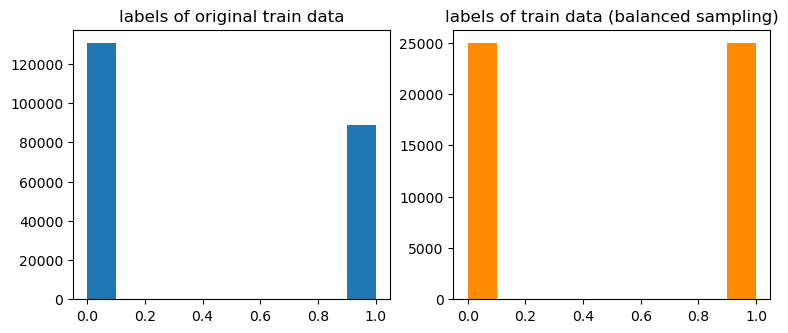

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (9, 3.5))
ax[0].hist(label_df["label"])
ax[1].hist(y_train.flatten(), color = "darkorange")
ax[0].set_title("labels of original train data")
ax[1].set_title("labels of train data (balanced sampling)")
plt.show()

## 2.2 Train and Test Distribution in RGB

When test data is available, it is better to compare distribution of train and test data. As shown in the histrogram of RGB respectively, train and test has similar distribution. 

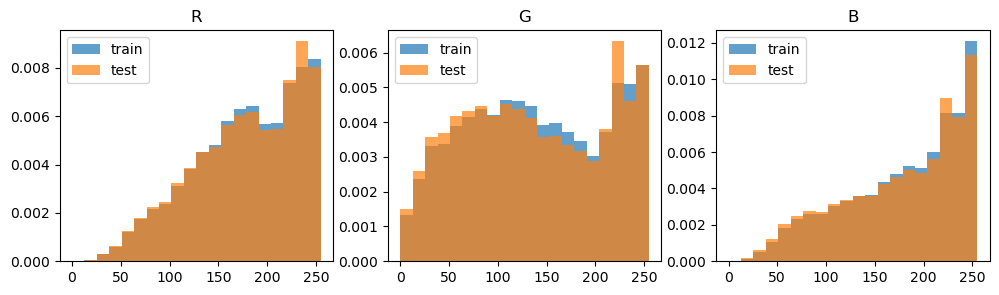

In [12]:
np.random.seed(1)
sample_train = np.random.choice(n_train, 5000)
sample_test = np.random.choice(n_test, 5000)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))

titles = ["R", "G", "B"]
for i in range(3):
    ax[i].hist(X_train[sample_train, :,:,i].flatten(), density = True, alpha = 0.7, bins = 20, label = "train")
    ax[i].hist(X_test[sample_test, :,:,i].flatten(), density = True, alpha = 0.7, bins = 20, label = "test")
    ax[i].set_title(titles[i])
    ax[i].legend()

## 2.3 Distribution of cancer and normal in RGB



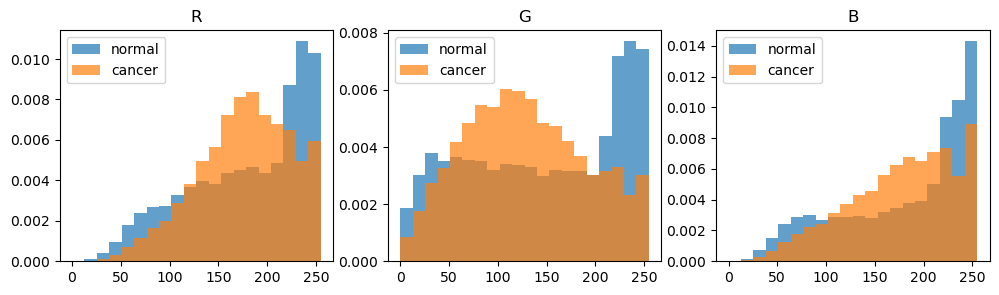

In [13]:
sample_pos = y_val.flatten() == 1
sample_neg = y_val.flatten() == 0

fig, ax = plt.subplots(1, 3, figsize = (12, 3))

titles = ["R", "G", "B"]
for i in range(3):
    ax[i].hist(X_val[sample_neg, :,:,i].flatten(), density = True, alpha = 0.7, bins = 20, label = "normal")
    ax[i].hist(X_val[sample_pos, :,:,i].flatten(), density = True, alpha = 0.7, bins = 20, label = "cancer")
    ax[i].set_title(titles[i])
    ax[i].legend()

## 2.4 Plot of photo

Since the distribution of cancer and normal are different in RGB, there should be visible difference in photos. According to images, there are lots of pink colored photo in cancer group, this color bias can be information for prediction. 

In [14]:
def plot_photo(X):
    
    N = X.shape[0]
    nc = 10
    nr = math.ceil(N/nc)
    
    fig, ax = plt.subplots(nr, nc, figsize = (14, nr*1.4))
    
    for k in range(N):
        i =  int(k/nc)
        j = k % nc
        ax[i,j].imshow(X[k])
        ax[i,j].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

### Normal (non-cancer)

In the normal (non-cancer) group, most of photo are **purple** colored. 

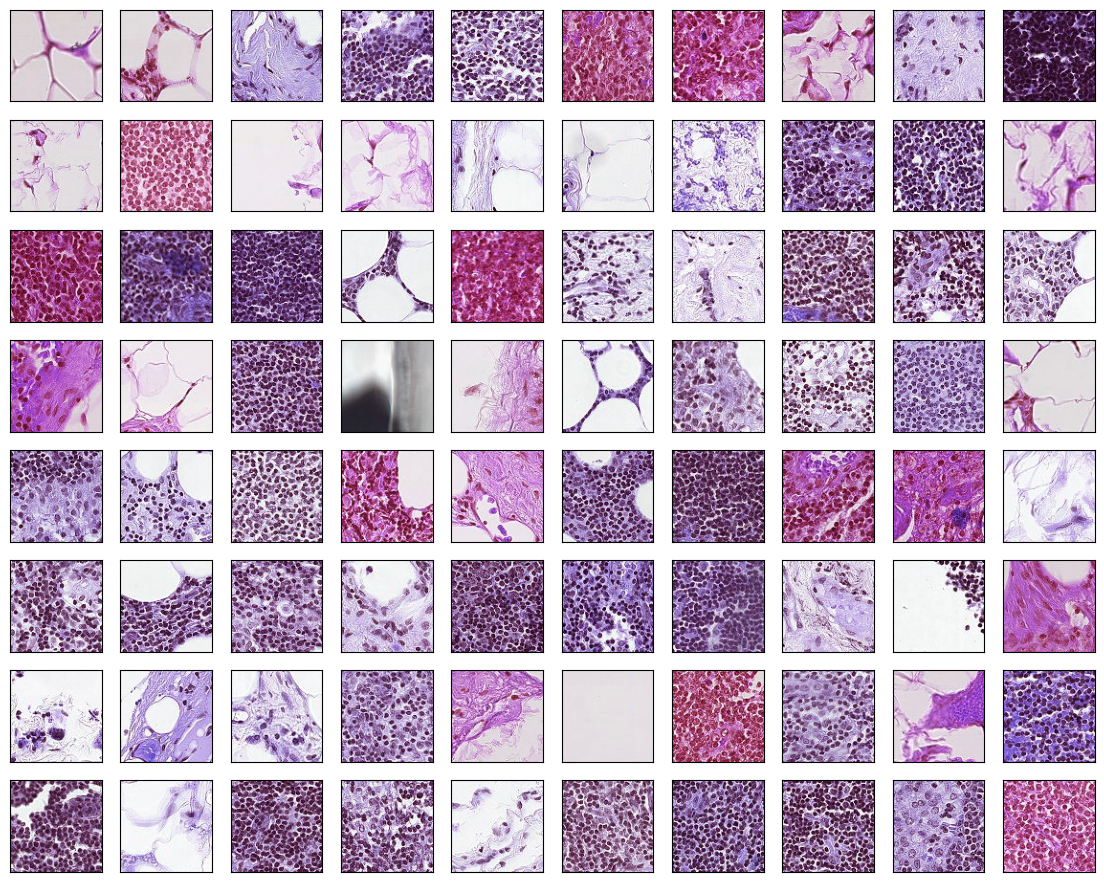

In [15]:
plot_photo(X_val[sample_neg][0:80])

### Cancers

There are more **pink** colored photo in cancer group compared with normal group.

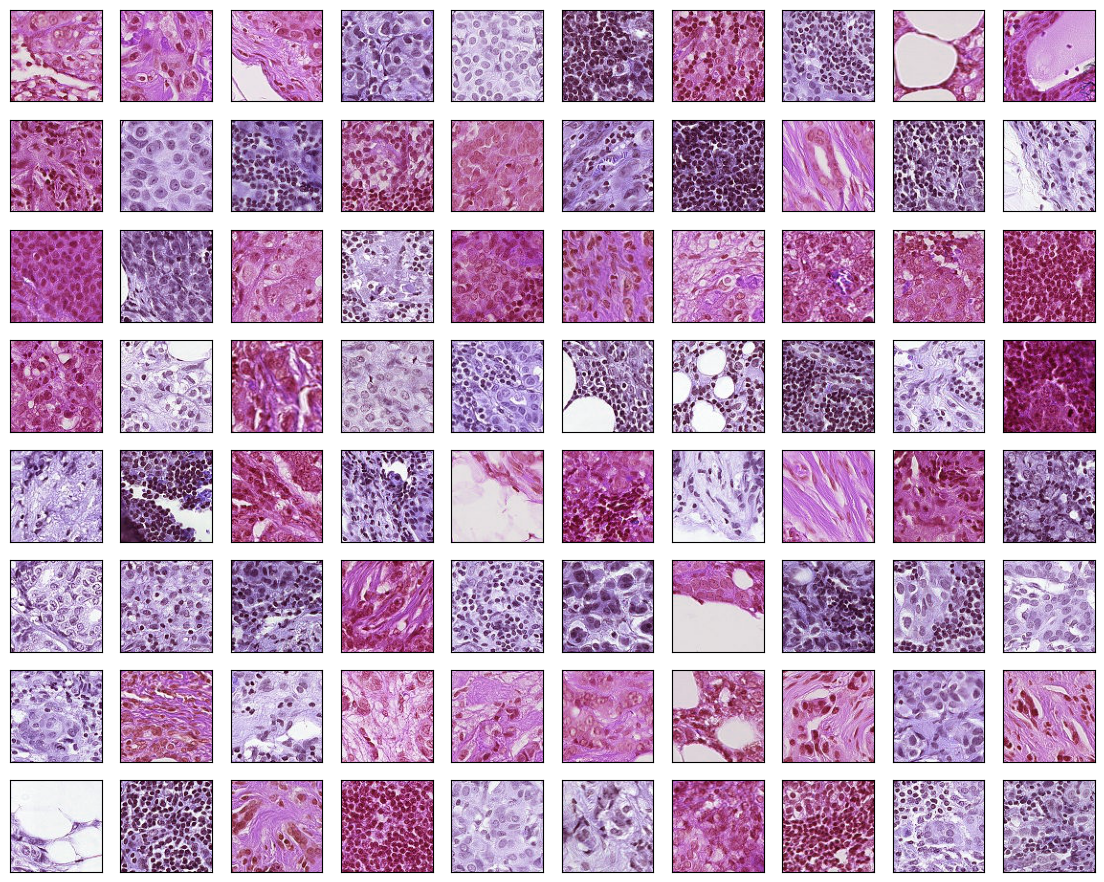

In [16]:
plot_photo(X_val[sample_pos][0:80])

## 2.5 Prediction from mean RGB value

Based on the above EDA, it seems to be possible to predict labels according to color of image. In this section, mean value of RGB of photo is calculated, and this feature is used for RandomForest Classifier. 

In [17]:
# Calculation of mean RGB
Z_train = np.zeros((n_train, 3))
Z_val = np.zeros((n_val, 3))
Z_test = np.zeros((n_test, 3))

for j in range(3):

    for i in range(n_train):
        Z_train[i,j] = np.mean(X_train[i,:,:,j])

    for i in range(n_val):
        Z_val[i,j] = np.mean(X_val[i,:,:,j])

    for i in range(n_test):
        Z_test[i,j] = np.mean(X_test[i,:,:,j])

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(Z_train, y_train.flatten())

RandomForestClassifier(max_depth=10, random_state=0)

As a result, validation auc is **0.844**.

In [20]:
yhat_train = clf.predict_proba(Z_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, yhat_train[:,1], pos_label=1)
train_auc = metrics.auc(fpr, tpr)

yhat_val = clf.predict_proba(Z_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val[:,1], pos_label=1)
val_auc = metrics.auc(fpr, tpr)

print("train auc", np.round(train_auc, 3))
print("validation auc", np.round(val_auc, 3))

train auc 0.869
validation auc 0.844


This prediction got **0.8151 in kaggle private score**. It means that CNN shall be much more accurate to be worth to use GPU and longer training time. 

In [21]:
#yhat_test = clf.predict_proba(Z_test)[:,1]

In [22]:
#test_submit = sample_df.copy()
#test_submit["label"] = yhat_test
#test_submit.to_csv('submission.csv',index=False)

In [11]:
del X_test
gc.collect()

155

## 2.6 Conclusion of EDA

**train and test data have similar distribution**

Since train and test images have similar distributions, it is possible to randomly select validation data from original train data. 

**There are bias in data** 

Cancer and normal have different distribution in RGB. It is even possible to predict cancer at auc 0.8 **only according to the mean color of a image**. Thus, CNN must achieve much higher result.

**Data cleaning plan**

The type of data is `uint8` that is small but still occupies large size of RAM. Preprocessing data will convert it to `float` which is too big. So, in this project, preprocess functions (`Rescale` and `Randomflip`) will be built in CNN model. 

# 3. CNN Tuning and Model Selection

In this chapter, 3 models of CNN are compared. Those models have 5 layers of Conv & MaxPool units.  

**models**

* model1: 5 x (Conv MaxPool)
* model2: 5 x (Conv Conv MaxPool)
* model3: 5 x (Conv Conv MaxPool) without Dropout

Following elements are common in these three models. Those settings are determined by many trial of training. Reasons are briefly described. 

**Common elements**

Models contain rescale and randomflip layer as preprocessing image.  

* Rescaling layer
* RandomFlip layer

As I tried some filter sizes, size = 3 was most stable and performance was better (faster learning and good accuracy) than size 5 and 7. MaxPooling layer should be after one or two Conv layers. I have tried Conv with stride = 2 instead of MaxPooling, but MaxPool was more stable. 

* Convolusion filter size = 3
* MaxPooling size = 2 stride = 2

Batch size and learning rate are closely related. I tried batch size 32, 64, and 128. 128 with default learning rate was the best. Furthermore, 50% of dropout is widely used in kaggle, and I can agree. When drop out ratio is small ( < 0.4), effect is not enough. For these model with 50,000 train images, the best epoch seems to be about 8, but I set epoch = 12, to clearly show overfitting symptoms. 

* batch size = 128 with adam lr = 0.0001 (default)
* 50% Dropout in Dense layer (except for model3)
* The number of epoch is 12 for all three models, which is enough to check overfitting.



## 5 x (Conv, MaxPool)

In [12]:
X_shape = X_train[0].shape

In [13]:
tf.keras.utils.set_random_seed(
    seed = 2
)

model1 = models.Sequential()

NF =64
FS = 3

model1.add(layers.Rescaling(scale=1./127.5, offset=-1., input_shape = X_shape))
model1.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=1, input_shape = X_shape))

model1.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same", input_shape = X_shape))
model1.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model1.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model1.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model1.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model1.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model1.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model1.add(layers.MaxPooling2D((2,2)))

FS = 3
NF = NF
model1.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5, seed = 1))
model1.add(layers.Dense(512*9, activation = "relu"))

model1.add(layers.Dense(2))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                    

In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model1.compile(
    optimizer = "adam",
    loss=loss_fn, 
    metrics=['accuracy'] 
    )

In [15]:
history1 = model1.fit(X_train, y_train, batch_size = 128, epochs = 12, validation_data = (X_val, y_val))
gc.collect()
tf.keras.backend.clear_session()

Epoch 1/12
391/391 [==============================] - 47s 95ms/step - loss: 0.4951 - accuracy: 0.7810 - val_loss: 0.4140 - val_accuracy: 0.8165
Epoch 2/12
391/391 [==============================] - 34s 88ms/step - loss: 0.3453 - accuracy: 0.8520 - val_loss: 0.2982 - val_accuracy: 0.8786
Epoch 3/12
391/391 [==============================] - 36s 91ms/step - loss: 0.2827 - accuracy: 0.8842 - val_loss: 0.2800 - val_accuracy: 0.8817
Epoch 4/12
391/391 [==============================] - 34s 88ms/step - loss: 0.2493 - accuracy: 0.8990 - val_loss: 0.2482 - val_accuracy: 0.9033
Epoch 5/12
391/391 [==============================] - 34s 88ms/step - loss: 0.2223 - accuracy: 0.9122 - val_loss: 0.2527 - val_accuracy: 0.8981
Epoch 6/12
391/391 [==============================] - 34s 88ms/step - loss: 0.1888 - accuracy: 0.9259 - val_loss: 0.3279 - val_accuracy: 0.8734
Epoch 7/12
391/391 [==============================] - 34s 88ms/step - loss: 0.1679 - accuracy: 0.9370 - val_loss: 0.2550 - val_accuracy:

In [16]:
gc.collect()
tf.keras.backend.clear_session()

In [17]:
def plot_scores(history):
    
    fig, ax = plt.subplots(1,2, figsize = (12, 5))
    ax[0].plot(history.history["accuracy"], label = "train")
    ax[0].plot(history.history["val_accuracy"], label = "val")
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("accuracy")
    ax[0].set_ylim([0.7,1])
    ax[0].set_title("Accuracy")
    ax[0].legend()

    ax[1].plot(history.history["loss"], label = "train")
    ax[1].plot(history.history["val_loss"], label = "val")
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("loss")
    ax[1].set_ylim([0,1])
    ax[1].set_title("Loss")
    ax[1].legend()
    
    plt.show()

Teh model started overfitting after epoch 5. Train loss decreased whereas validation loss increased. 

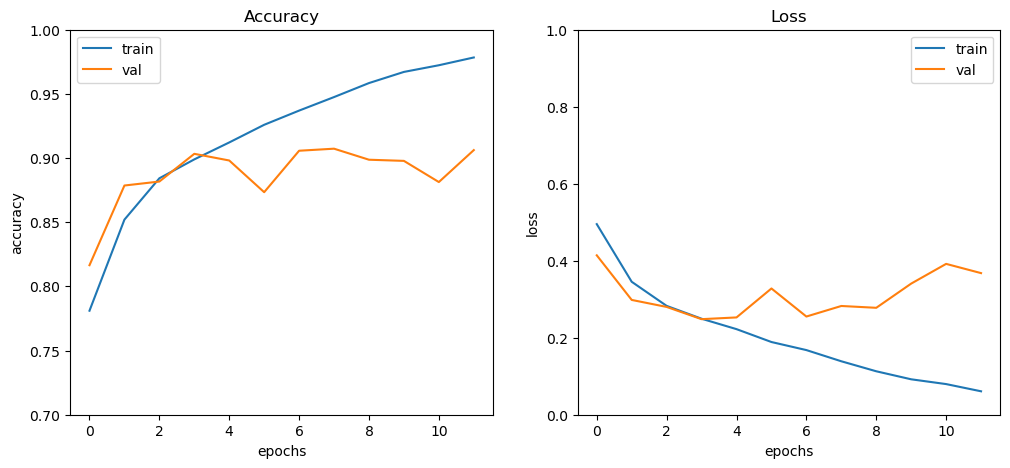

In [18]:
plot_scores(history1)

**validation auc**

Two predictions are compared. First, prediction from original image. It got **auc 0.959**. Another one is ensemble of predictions from flipped images. It got **auc 0.975**. The result is improved because CNN is sensitive to image's angle.

In [22]:
yhat_val = model1.predict(X_val)
yhat_val = tf.nn.softmax(yhat_val).numpy()[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
val_auc = metrics.auc(fpr, tpr)
print("val auc", val_auc)

313/313 [==============================] - 2s 5ms/step
val auc 0.9595596290301631


In [23]:
def pred_val(model):
    
    #original
    yhat_test1 = model.predict(X_val)
    yhat_test1 = tf.nn.softmax(yhat_test1).numpy()[:,1]
    
    gc.collect()
    
    #flipped
    yhat_test2 = model.predict(X_val[:,::-1,::-1,:])
    yhat_test2 = tf.nn.softmax(yhat_test2).numpy()[:,1]
    
    gc.collect()
    
    #flipped
    yhat_test3 = model.predict(X_val[:,::-1,:,:])
    yhat_test3 = tf.nn.softmax(yhat_test3).numpy()[:,1]
    
    gc.collect()
    
    #flipped
    yhat_test4 = model.predict(X_val[:,:,::-1,:])
    yhat_test4 = tf.nn.softmax(yhat_test4).numpy()[:,1]
    
    gc.collect()
    
    #average
    yhat_test =  (yhat_test1 + yhat_test2 + yhat_test3 + yhat_test4)/4
    
    return yhat_test

In [24]:
yhat_val = pred_val(model1)
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
val_auc = metrics.auc(fpr, tpr)
print("val auc (ensembled)", val_auc)

313/313 [==============================] - 2s 5ms/step
val auc (ensembled) 0.9761100130965686


## 5 x (Conv Conv MaxPool)

In [35]:
tf.keras.utils.set_random_seed(
    seed = 2
)

model = models.Sequential()

NF =64
FS = 3

model.add(layers.Rescaling(scale=1./127.5, offset=-1., input_shape = X_shape))
model.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=1, input_shape = X_shape))

model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same", input_shape = X_shape))
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.MaxPooling2D((2,2)))

FS = 3
NF = NF
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5, seed = 1))
model.add(layers.Dense(512*9, activation = "relu"))

model.add(layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                        

In [36]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer = "adam",
    loss=loss_fn, 
    metrics=['accuracy'] 
    )

In [37]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 12, validation_data = (X_val, y_val))

Epoch 1/12
391/391 [==============================] - 80s 189ms/step - loss: 0.6031 - accuracy: 0.6607 - val_loss: 0.4475 - val_accuracy: 0.8059
Epoch 2/12
391/391 [==============================] - 66s 169ms/step - loss: 0.4136 - accuracy: 0.8183 - val_loss: 0.3618 - val_accuracy: 0.8477
Epoch 3/12
391/391 [==============================] - 68s 175ms/step - loss: 0.3342 - accuracy: 0.8605 - val_loss: 0.3147 - val_accuracy: 0.8676
Epoch 4/12
391/391 [==============================] - 68s 175ms/step - loss: 0.3115 - accuracy: 0.8712 - val_loss: 0.2890 - val_accuracy: 0.8821
Epoch 5/12
391/391 [==============================] - 66s 169ms/step - loss: 0.2673 - accuracy: 0.8919 - val_loss: 0.2503 - val_accuracy: 0.9022
Epoch 6/12
391/391 [==============================] - 66s 170ms/step - loss: 0.2387 - accuracy: 0.9063 - val_loss: 0.2381 - val_accuracy: 0.9076
Epoch 7/12
391/391 [==============================] - 66s 170ms/step - loss: 0.2198 - accuracy: 0.9139 - val_loss: 0.2344 - val_ac

In [38]:
gc.collect()
tf.keras.backend.clear_session()

Compared with the previous model, training accuracy is slightly lower but validation accuracy was improved. Overfitting is mitigated by additional conv layer. 

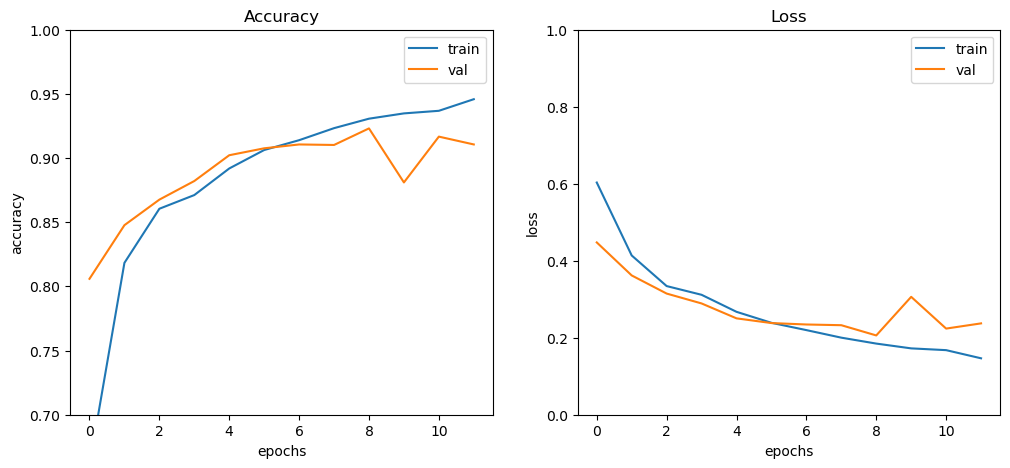

In [39]:
plot_scores(history)

**validation auc**

Prediction of single image and flipped images are compared. 

In [40]:
#single image
yhat_val = model.predict(X_val)
yhat_val = tf.nn.softmax(yhat_val).numpy()[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
val_auc = metrics.auc(fpr, tpr)
print("val auc", val_auc)

313/313 [==============================] - 4s 11ms/step
val auc 0.9683200969543707


In [41]:
#flipped and ensembled
yhat_val = pred_val(model)
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
val_auc = metrics.auc(fpr, tpr)
print("val auc (ensembled)", val_auc)

313/313 [==============================] - 3s 11ms/step
val auc (ensembled) 0.9775868623243376


## 5 x (Conv Conv MaxPool) without Dropout

Next, Dropout layer is removed from the previous architecture. Others are the same. 

In [42]:
tf.keras.utils.set_random_seed(
    seed = 2
)

model3 = models.Sequential()

NF =64
FS = 3

model3.add(layers.Rescaling(scale=1./127.5, offset=-1., input_shape = X_shape))
model3.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=1, input_shape = X_shape))

model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same", input_shape = X_shape))
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.MaxPooling2D((2,2)))


FS = 3
NF = NF*2
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.MaxPooling2D((2,2)))

FS = 3
NF = NF
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.Conv2D(NF, (FS,FS), activation = "relu", padding = "same"))
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Flatten())
#model3.add(layers.Dropout(0.5, seed = 1))
model3.add(layers.Dense(512*9, activation = "relu"))

model3.add(layers.Dense(2))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                        

In [43]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model3.compile(
    optimizer = "adam",
    loss=loss_fn, 
    metrics=['accuracy'] 
    )

In [44]:
history3 = model3.fit(X_train, y_train, batch_size = 128, epochs = 12, validation_data = (X_val, y_val))

Epoch 1/12
391/391 [==============================] - 75s 181ms/step - loss: 0.6415 - accuracy: 0.6167 - val_loss: 0.4797 - val_accuracy: 0.7795
Epoch 2/12
391/391 [==============================] - 69s 176ms/step - loss: 0.3901 - accuracy: 0.8260 - val_loss: 0.3500 - val_accuracy: 0.8483
Epoch 3/12
391/391 [==============================] - 68s 175ms/step - loss: 0.3205 - accuracy: 0.8628 - val_loss: 0.3084 - val_accuracy: 0.8737
Epoch 4/12
391/391 [==============================] - 67s 173ms/step - loss: 0.2878 - accuracy: 0.8790 - val_loss: 0.2954 - val_accuracy: 0.8796
Epoch 5/12
391/391 [==============================] - 69s 176ms/step - loss: 0.2710 - accuracy: 0.8877 - val_loss: 0.2642 - val_accuracy: 0.8932
Epoch 6/12
391/391 [==============================] - 69s 176ms/step - loss: 0.2407 - accuracy: 0.9034 - val_loss: 0.2958 - val_accuracy: 0.8777
Epoch 7/12
391/391 [==============================] - 68s 174ms/step - loss: 0.2210 - accuracy: 0.9117 - val_loss: 0.2390 - val_ac

In [45]:
gc.collect()
tf.keras.backend.clear_session()

train accuracy kept increasing while validation accuracy stayed around 0.9, it is a sort of overfitting.

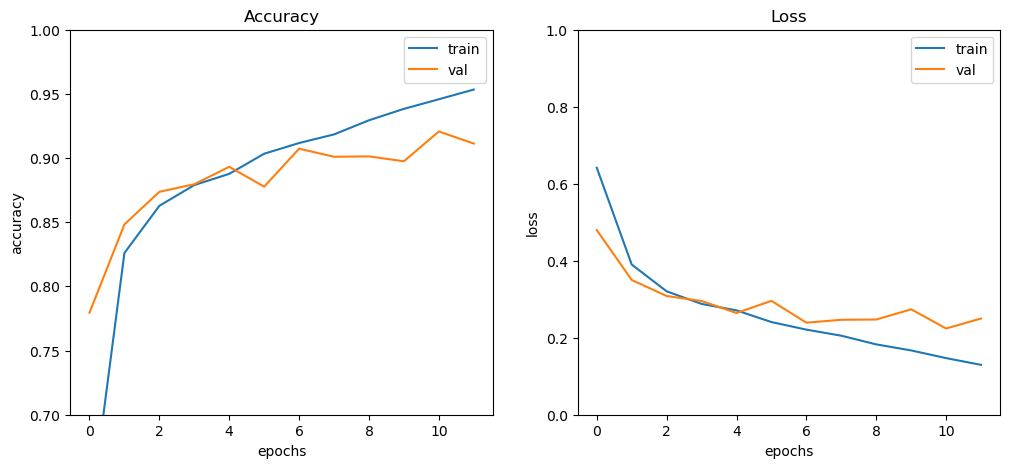

In [46]:
plot_scores(history3)

In [47]:
yhat_val = model3.predict(X_val)
yhat_val = tf.nn.softmax(yhat_val).numpy()[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
val_auc = metrics.auc(fpr, tpr)
print("val auc", val_auc)

313/313 [==============================] - 4s 11ms/step
val auc 0.9704654356236186


## Results 

Validation accuracy and loss of three models are plotted in the below figure. Model1 converged fastest, but after 4 epochs, model 2 exceeded it. The best epoch was 9 (at x = 8 in figure) in model2 that had highest accuracy of all. Thus, the **model 2 is the best architecture**. A similar model in [other notebook](https://www.kaggle.com/code/hidetaketakahashi/cancerdetection-cnn2) achieved auc 0.93 in kaggle private score. `LeakyRelu` activation is selected there to avoid dead neuron problem happened in [the model with relu](https://www.kaggle.com/code/hidetaketakahashi/cancerdetection-cnn2-relu). 

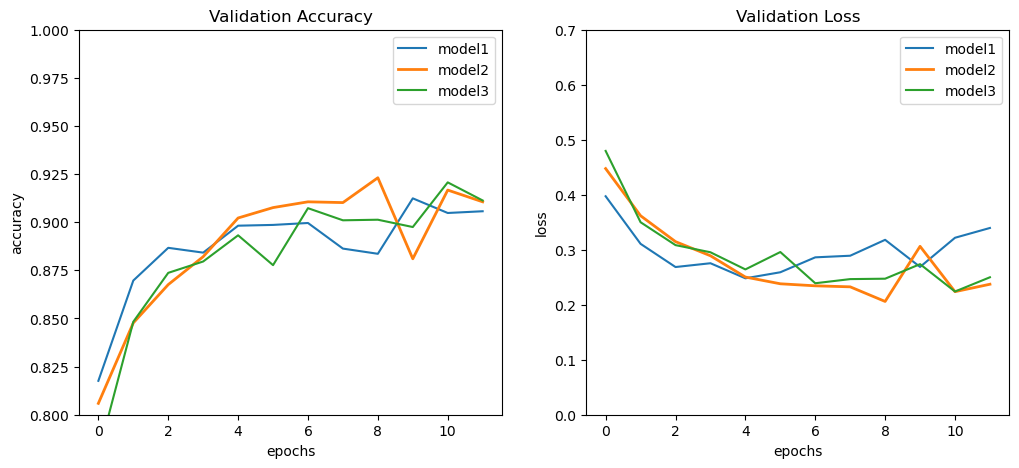

In [61]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
ax[0].plot(history1.history["val_accuracy"], label = "model1")
ax[0].plot(history.history["val_accuracy"], label = "model2", lw = 2)
ax[0].plot(history3.history["val_accuracy"], label = "model3")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")
ax[0].set_ylim([0.8,1])
ax[0].set_title("Validation Accuracy")
ax[0].legend()

ax[1].plot(history1.history["val_loss"], label = "model1")
ax[1].plot(history.history["val_loss"], label = "model2", lw = 2)
ax[1].plot(history3.history["val_loss"], label = "model3")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_ylim([0,0.7])
ax[1].set_title("Validation Loss")
ax[1].legend()

plt.show()

# 4. Analysis: Where is cancer?

Even though CNN is kind of black box in calculation, we can check which part of image makes prediction confident. It is possible by selecting samples of high probability of positive. Then cropping a part of image and check prediction. When probability drops significantly, this area may contain cancer cells.

In [48]:
yhat_val = model.predict(X_val)
yhat_val = tf.nn.softmax(yhat_val).numpy()[:,1]
pos_samples = np.where(yhat_val > 0.98)[0]
pos_samples[0:10]

313/313 [==============================] - 3s 11ms/step


array([ 0,  1,  2,  5,  6,  9, 10, 12, 15, 16])

In [57]:
def plot_analysis(ID, size = 32, stride = 32):
    print("true label = ", y_val[ID][0], " index", ID)
    
    fig, ax = plt.subplots(figsize = (3, 3))
    ax.imshow(X_val[ID])
    ax.set_title("original image")
    
    fig, ax = plt.subplots(3, 3, figsize = (8, 8))

    for i in range(3):
        for j in range(3):
            X_sample = X_val[ID].copy()
            start_x = i*stride
            end_x = i*stride + size
            start_y = j*stride
            end_y = j*stride + size
            
            #cropping image
            X_sample[start_x:end_x, start_y:end_y] = 255
            
            #predict probability
            prob = model.predict(X_sample.reshape(1,96,96,3), verbose = 0)
            prob = tf.nn.softmax(prob).numpy()[:,1]
            
            #show cropped image
            ax[i,j].imshow(X_sample)
            
            #write prob as title
            ax[i,j].set_title("p = " + str(np.round(prob[0], 3)))
            ax[i,j].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)


In the following case, probability dropped when **bottom left** zone is copped. 

true label =  1  index 10


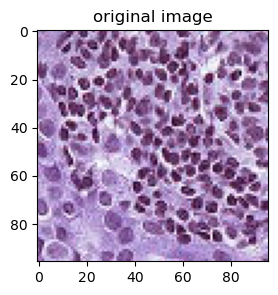

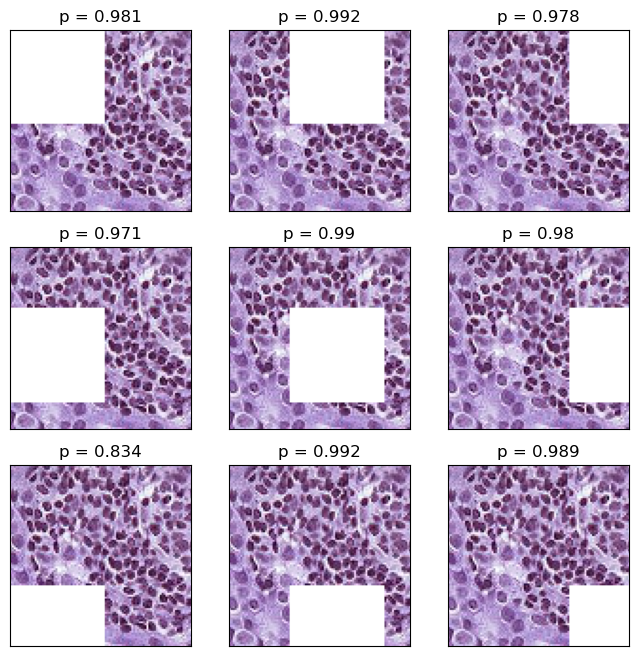

In [58]:
#index 10
plot_analysis(10, 50)

In the next case, probability dropped when **upper middle** zone is cropped. 

true label =  1  index 1512


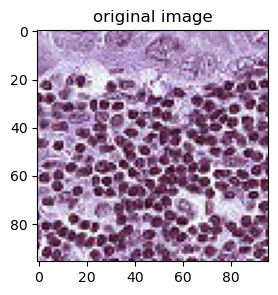

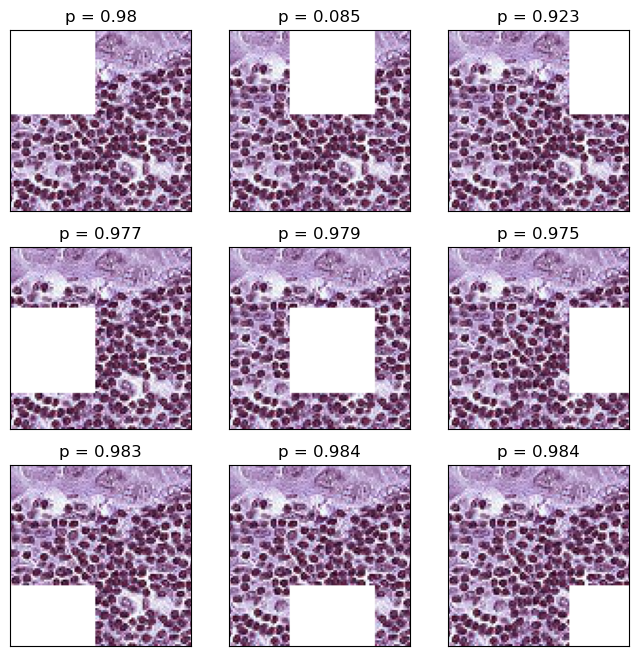

In [59]:
#index 1512
plot_analysis(1512, 45)

# 5. Conclusion

The model2 [trained with 100,000 images](https://www.kaggle.com/code/hidetaketakahashi/cancerdetection-cnn2) achieved target auc in kaggle private score. It consists of 5 layers of `Conv` `Conv` `MaxPooling` units with 50% `Dropout` at `FC layer`. Here are some findings from this project.

**Convolution layer migated overfitting**

model 1 (**Conv&MaxPool**) converged faster but it had obvious overfitting, and model 2 (**Conv&Conv&MaxPool**) mitigated overfitting. Validation accuracy was also improved by additional conv layers.  

**Dropout layer improved validation accuracy**

Model 2 (with dropout) has better accuracy than model 3 (without dropout) that demonstrated effect of dropout. Dropout is well known technique to mitigate overfit, but it also improves accuracy according to this result.

**Leaky relu solved dead neuron**

It is not described in this notebook, but by comparing with other notebooks ([leaky relu](https://www.kaggle.com/code/hidetaketakahashi/cancerdetection-cnn2) and [relu](https://www.kaggle.com/hidetaketakahashi/cancerdetection-cnn2-relu)),`Leaky relu` avoided dead neuron caused by `relu` when the model has many layers. When many of neurons are dead, prediction accuracy does not increase from 0.5. 

**Flipping image and ensemble predictions is effective**

To get higher auc, input image for testing is flipped horizontally and vertically. Thus, one image has four prediction and they are ensembled. `yhat` = `mean`(`yhat1`(original), `yhat2`(vertical flip), `yhat3` (horizontal flip), `yhat4` (horizontal and vertical flip)). Almost everytime, it improved auc. 

**CNN can be visualized somehow**

It is difficult to figure out which cells are cancers for non-professional persons. However, some technique of CNN can assist diagnosis. By cropping a part of image, and check probability of cancer by CNN, we can guess what are cancer cells look like.  